In [1]:
import numpy as np
from scipy import optimize as sp_optimize

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.inference.penalized_regression import PenalizedRegression as PLR

In [2]:
def sample_mixgauss(wk, sk, size):
    runif = np.random.uniform(0, 1, size = size)
    gcomp = np.digitize(runif, np.cumsum(wk))
    x = np.zeros(size)
    for i, gc in enumerate(gcomp):
        if sk[gc] > 0:
            x[i] = np.random.normal(0, sk[gc]) 
    return x

def NM_sample(mean, std = 1.0):
    p   = mean.shape[0]
    cov = np.eye(p) * std * std
    y   = np.random.multivariate_normal(mean, cov)
    return y

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

In [3]:
btrue = np.load('../trendfiltering_examples/target_b.npy')

In [4]:
p = 10000
k = 4
strue = 1.0


np.random.seed(100)
winit = np.array([0.7, 0.2, 0.05, 0.05])
#sk = np.logspace(-1, k-2, k)
_, sk = initialize_ash_prior(k, scale = 10)
btrue = sample_mixgauss(winit, sk, p)

dj = np.ones(p)

In [5]:
sk

array([0.        , 0.77827941, 2.16227766, 4.62341325])

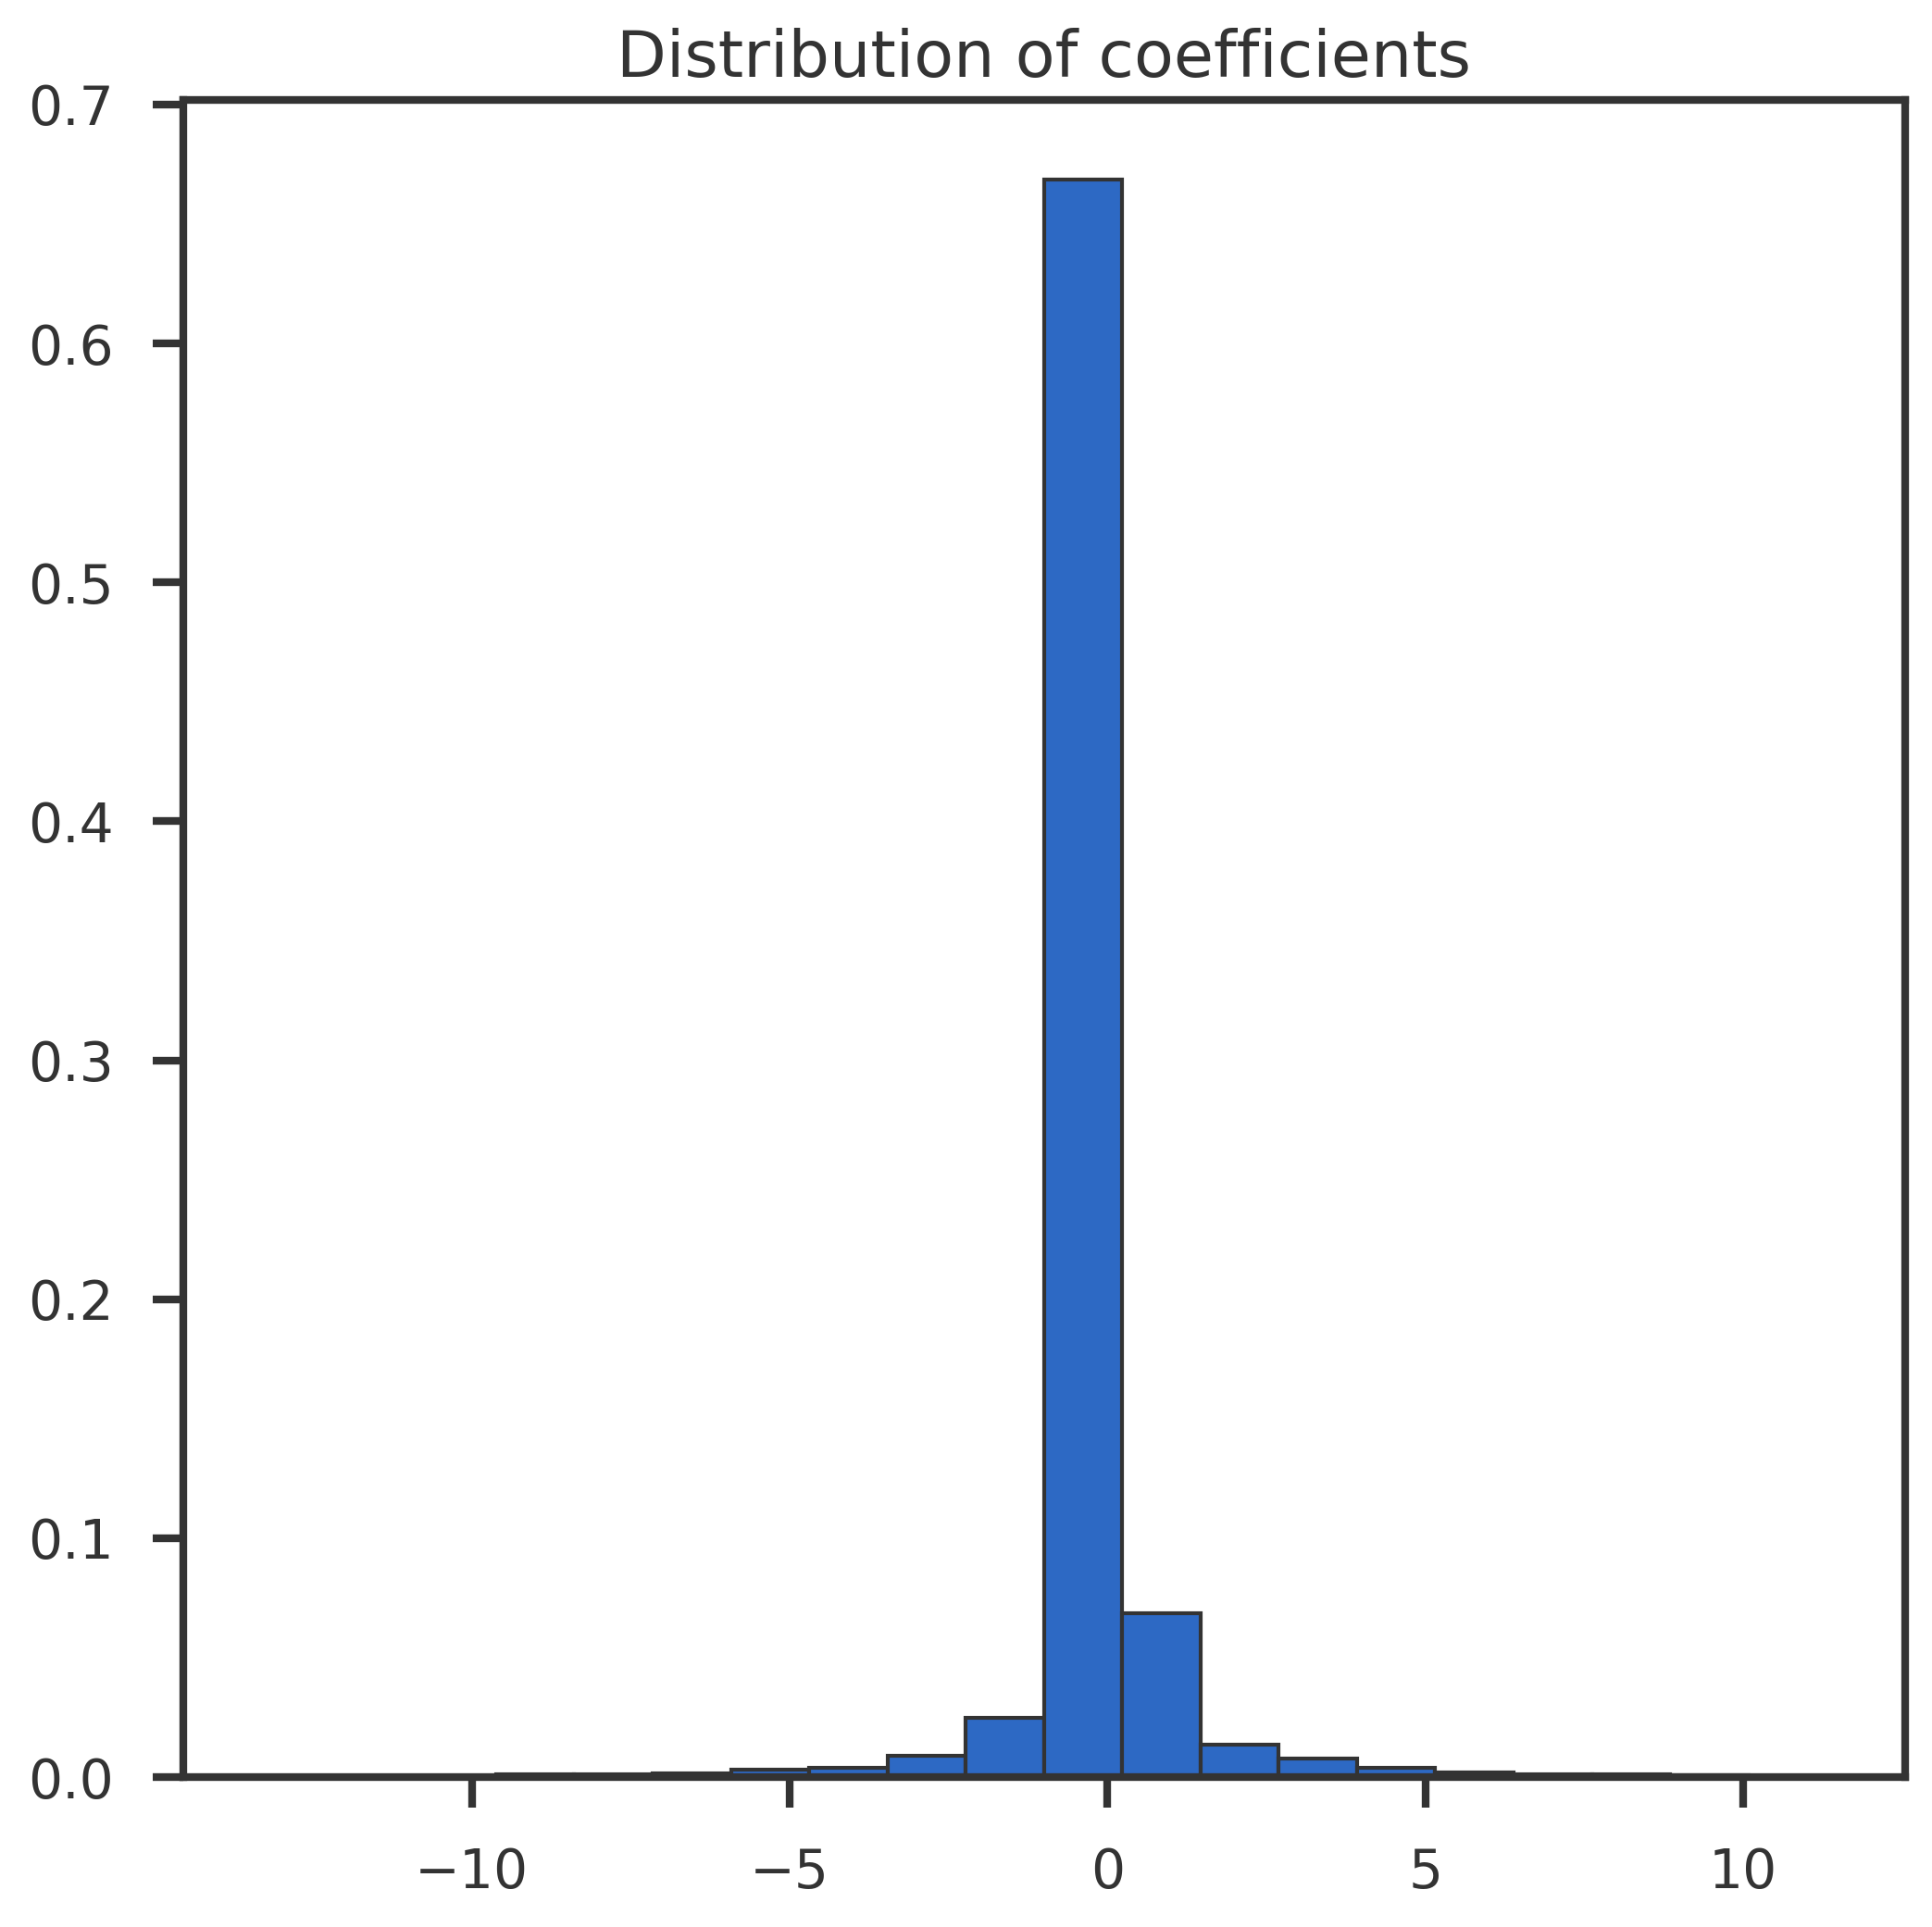

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(btrue, density = True)
#ax1.hist(mean)
ax1.set_title("Distribution of coefficients")
plt.show()

In [7]:
def softmax(x, base = np.exp(1)):
    if base is not None:
        beta = np.log(base)
        x = x * beta
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis = 0, keepdims = True)

def penalty_operator(z, wk, std, sk, dj):
    nm = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    tvar = (std * std) / dj
    lambdaj = - nm.logML - 0.5 * tvar * np.square(nm.logML_deriv)
    return lambdaj

def shrinkage_operator(nm):
    M        = nm.y + nm.yvar * nm.logML_deriv
    M_bgrad  = 1       + nm.yvar * nm.logML_deriv2
    M_wgrad  = nm.yvar.reshape(-1, 1) * nm.logML_deriv_wderiv
    M_s2grad = (nm.logML_deriv / nm._d) + (nm.yvar * nm.logML_deriv_s2deriv)
    return M, M_bgrad, M_wgrad, M_s2grad

def unshrink_b(b, std, wk, sk, dj, theta = None, max_iter = 100, tol = 1e-8):
    # this is the initial value of theta
    if theta is None:
        theta = np.zeros_like(b)
    # Newton-Raphson iteration
    for itr in range(max_iter):
        nmash = NormalMeansASHScaled(theta, std, wk, sk, d = dj)
        Mtheta, Mtheta_bgrad, _, _ = shrinkage_operator(nmash)
        theta_new = theta - (Mtheta - b) / Mtheta_bgrad
        diff = np.sum(np.square(theta_new - theta))
        theta = theta_new
        obj = np.sum(- nmash.logML - 0.5 * nmash.yvar * np.square(nmash.logML_deriv))
        print(obj)
        if diff <= tol:
            break
    return theta

def shrink_theta(z, std, wk, sk, dj):
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    Mb = shrinkage_operator(nmash)[0]
    return Mb

def penalty_operator_lagrangian(z, wk, std, sk, dj, lgrng, b):
    Mt  = shrink_theta(z, std, wk, sk, dj)
    hwt = penalty_operator(z, wk, std, sk, dj)
    obj = np.sum(hwt) + np.sum(lgrng * (Mt - b))
    return obj

def penalty_operator_lagrangian_deriv(z, wk, std, sk, dj, lgrng, b):
    '''
    The Normal Means model
    '''
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    '''
    gradient w.r.t lambda_j (lagrangian penalty)
    '''
    M, M_bgrad, M_wgrad, M_s2grad  = shrinkage_operator(nmash)
    dLdl = M - b
    '''
    gradient w.r.t wk (prior mixture coefficients)
    '''
    tvar  = (strue * strue) / dj
    v2_ld_ldwd = tvar.reshape(-1, 1) * nmash.logML_deriv.reshape(-1, 1) * nmash.logML_deriv_wderiv
    ## gradient of first term and second term of the lagrangian
    l1_wgrad = - nmash.logML_wderiv - v2_ld_ldwd
    l2_wgrad = lgrng.reshape(-1, 1) * M_wgrad
    dLdw = np.sum(l1_wgrad + l2_wgrad, axis = 0)
    '''
    gradient w.r.t theta
    '''
    l1_tgrad = - nmash.logML_deriv  - tvar * nmash.logML_deriv * nmash.logML_deriv2
    l2_tgrad = lgrng * (1 + tvar * nmash.logML_deriv2)
    dLdt = l1_tgrad + l2_tgrad
    return dLdl, dLdw, dLdt

def objective_numeric_lagrangian(params, std, sk, dj, b, p, k, softmax_base):
    zj = params[:p]
    lj = params[p:2*p]
    ak = params[2*p:]
    wk = softmax(ak, base = softmax_base)
    dLdl, dLdw, dLdt = penalty_operator_lagrangian_deriv(zj, wk, strue, sk, dj, lj, btrue)
    akjac = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
    dLda = np.sum(dLdw * akjac, axis = 1)
    obj = np.sqrt(np.sum(np.square(dLdl)) + np.sum(np.square(dLda)) + np.sum(np.square(dLdt)))
    return obj

### Estimation of "true" $\theta$

Here, we estimate $\theta$ by numerically inverting $M$ using Newton-Raphson algorithm. To check if the estimate of $\theta$ is reasonable, we compare $M(\theta)$ with true $b$. We call this estimate as "true" $\theta$.

10361.578396652541
52145.20621844025
12709.249668933955
18951.12516536038
13710.582178168755
16302.75719487392
14695.431996730858
14749.744030844304
14742.938124843095
14742.913901521071


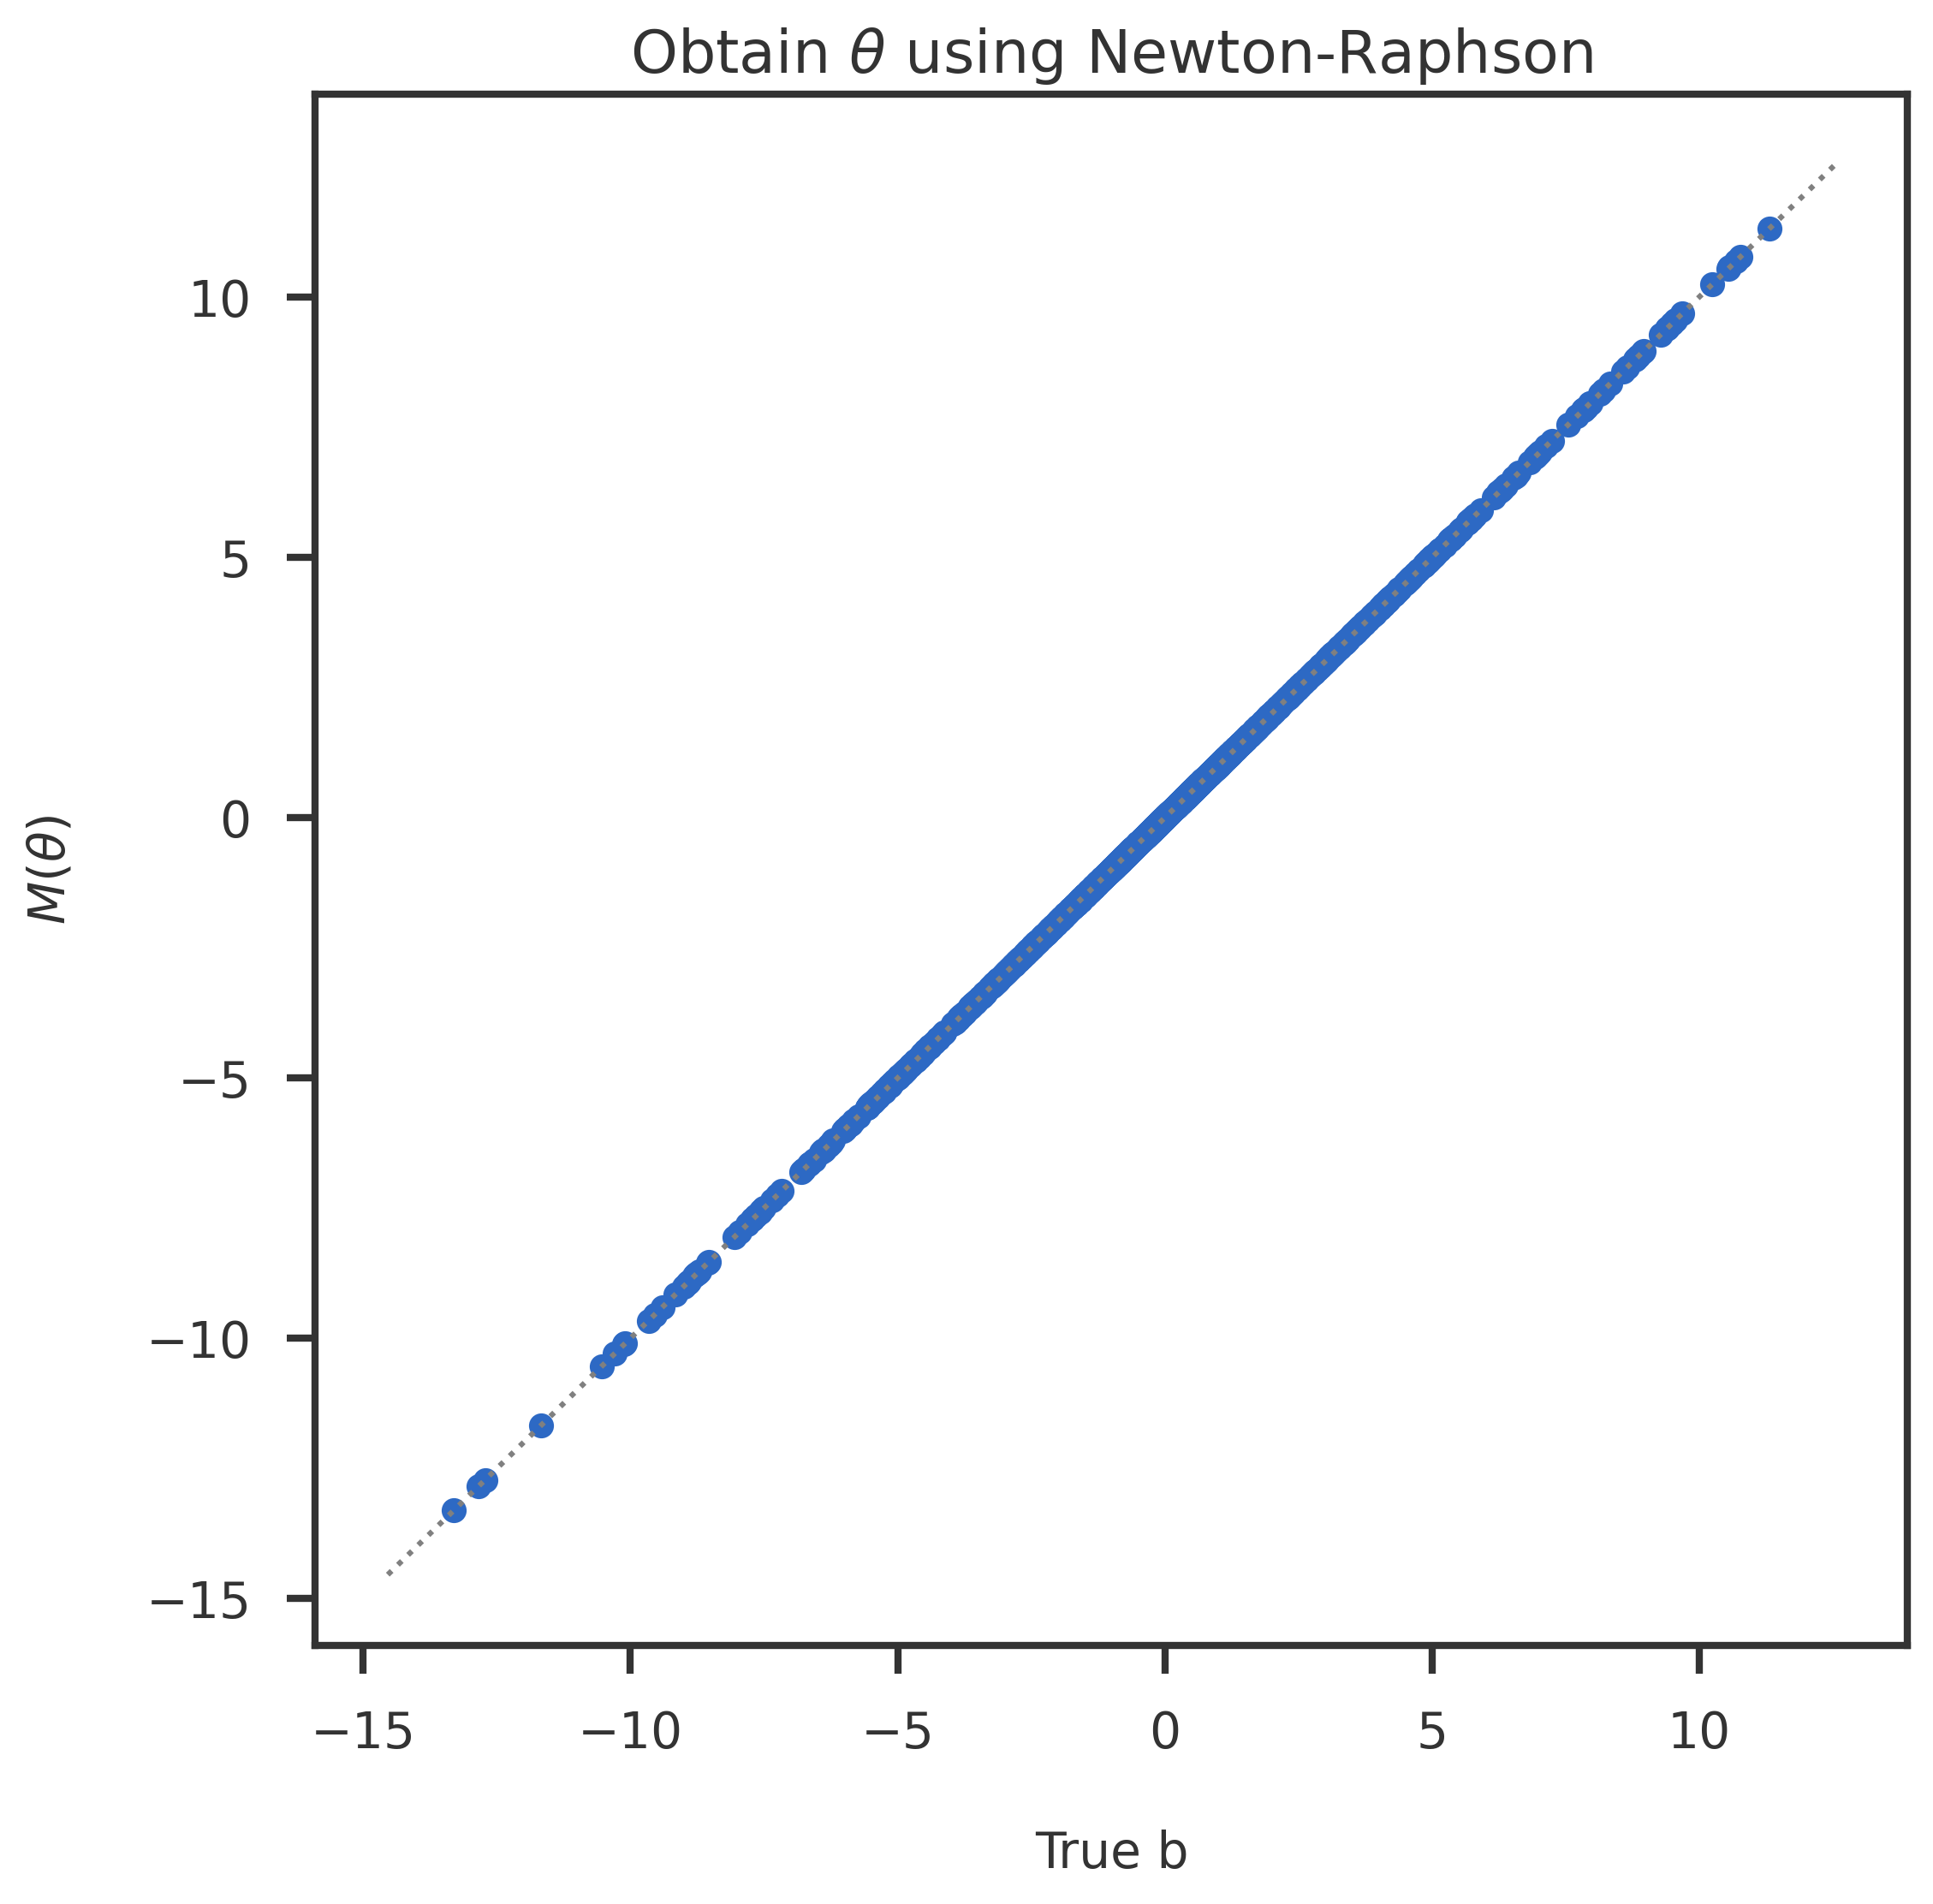

In [8]:
z_newraph = unshrink_b(btrue, strue, winit, sk, dj)
b_newraph = shrink_theta(z_newraph, strue, winit, sk, dj)
# objtrue   = penalty_operator(z_newraph, winit, strue, sk, dj)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(btrue, b_newraph)
ax1.set_xlabel("True b")
ax1.set_ylabel(r"$M(\theta)$")
ax1.set_title(r"Obtain $\theta$ using Newton-Raphson" )
mpl_utils.plot_diag(ax1)

### Estimation of $\theta$ from minimizing the penalty function

In [9]:
# z = np.random.rand(p)
# softmax_base = np.exp(1)
# #winit, _ = initialize_ash_prior(k)
# akinit = np.log(winit + 1e-8) / np.log(softmax_base)
# s2init = strue * strue

In [10]:
'''
Use mr.ash.pen for the penalty function
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True, optimize_s = False,
                debug = False, display_progress = False, calculate_elbo = False, 
                prior_optim_method = 'softmax',
                maxiter = 2000, tol = 1e-8)


plr_lbfgs.fit(np.eye(p), btrue, sk, binit = btrue, winit = winit, 
              s2init = strue * strue)

mr.ash.pen terminated at iteration 154.


In [11]:
sk

array([0.        , 0.77827941, 2.16227766, 4.62341325])

In [12]:
# def get_init_w_theta(p, btrue, old_theta, wk, sk, s2init):
#     plr_init = PLR(method = 'L-BFGS-B', is_prior_scaled = True, optimize_s = False,
#                        debug = False, display_progress = False, calculate_elbo = False, 
#                        maxiter = 2000, tol = 1e-8)
#     plr_init.fit(np.eye(p), btrue, sk, binit = old_theta, winit = wk, s2init = s2init, is_binit_coef = False)
#     return plr_init.theta, plr_init.prior, plr_init


# '''
# Initialization of theta and w for mr.ash.pen
# '''
# s2init = strue * strue
# scale = 2.0
# wk, _ = initialize_ash_prior(k, scale = scale)
# sk = np.arange(k) * scale

# theta_init, winit, plr_init = get_init_w_theta(p, btrue, btrue, wk, sk, s2init)
# has_low_sk = winit[-1] > 1e-4
# has_high_sk = winit[0] > 0.999
# has_unstable_sk = has_low_sk or has_high_sk
# print("Low sk", has_low_sk, "High sk", has_high_sk)

# while has_unstable_sk:
#     print (scale, winit[0], winit[-1])
#     if has_low_sk:
#         scale = scale * 2
#     elif has_high_sk:
#         scale = scale / 2
#     sk = np.arange(k) * scale
#     theta_init, winit, plr_init = get_init_w_theta(p, btrue, theta_init, wk, sk, s2init)
#     has_low_sk = winit[-1] > 1e-4
#     has_high_sk = winit[0] > 0.999
#     has_unstable_sk = has_low_sk or has_high_sk
# # winit = mix_gauss.emfit(genlasso_b, sk)
# print(winit)

mr.ash.pen terminated at iteration 11.
Low sk False High sk True
2.0 0.9999999886497889 3.113208083691312e-09
mr.ash.pen terminated at iteration 17.
1.0 0.9999999772423617 5.443967885924922e-10
mr.ash.pen terminated at iteration 22.
0.5 0.9999999628748761 1.5213128555805553e-09
mr.ash.pen terminated at iteration 21.
0.25 0.9999998336652066 6.5654145424231755e-09
mr.ash.pen terminated at iteration 20.
0.125 0.9999995891118713 1.3627997848327341e-08
mr.ash.pen terminated at iteration 18.
0.0625 0.9999982583783932 5.490176462208882e-08
mr.ash.pen terminated at iteration 16.
0.03125 0.9999929289453563 2.203527111185042e-07
mr.ash.pen terminated at iteration 14.
0.015625 0.9999715743245047 8.840154018521845e-07
mr.ash.pen terminated at iteration 12.
0.0078125 0.999885689266681 3.5494041414398434e-06
mr.ash.pen terminated at iteration 10.
0.00390625 0.9995374762451892 1.4308361311692751e-05
mr.ash.pen terminated at iteration 8.
[9.98114197e-01 1.53953691e-03 2.88158553e-04 5.81070739e-05]


In [12]:
[softmax(x) for x in plr_lbfgs.prior_path]

[array([0.86462194, 0.09873545, 0.01864971, 0.0179929 ]),
 array([0.97525762, 0.01664726, 0.00337962, 0.0047155 ]),
 array([0.98268632, 0.01082136, 0.00219792, 0.0042944 ]),
 array([9.89418429e-01, 4.55132778e-03, 8.35953845e-04, 5.19428892e-03]),
 array([9.87961965e-01, 1.56750332e-03, 2.07244574e-04, 1.02632867e-02]),
 array([9.85299745e-01, 3.25014190e-04, 3.33792586e-05, 1.43418611e-02]),
 array([9.84602796e-01, 4.91637992e-06, 3.54212955e-07, 1.53919338e-02]),
 array([9.77606028e-01, 1.44506415e-07, 6.71974522e-09, 2.23938204e-02]),
 array([9.77242144e-01, 8.92393863e-09, 3.35881202e-10, 2.27578463e-02]),
 array([9.75875966e-01, 5.89465544e-10, 1.78076123e-11, 2.41240330e-02]),
 array([9.71371916e-01, 3.30262291e-11, 8.10579488e-13, 2.86280839e-02]),
 array([9.67527542e-01, 3.83366306e-13, 7.26504309e-15, 3.24724580e-02]),
 array([9.64789300e-01, 8.44941383e-14, 1.50531797e-15, 3.52106996e-02]),
 array([9.71189269e-01, 4.19579199e-14, 5.56141957e-16, 2.88107309e-02]),
 array([9.66

In [13]:
sk

array([0.        , 0.77827941, 2.16227766, 4.62341325])

In [14]:
z_newraph = unshrink_b(btrue, strue, winit, sk, dj)
b_newraph = shrink_theta(z_newraph, strue, winit, sk, dj)

10361.578396652541
52145.20621844025
12709.249668933955
18951.12516536038
13710.582178168755
16302.75719487392
14695.431996730858
14749.744030844304
14742.938124843095
14742.913901521071


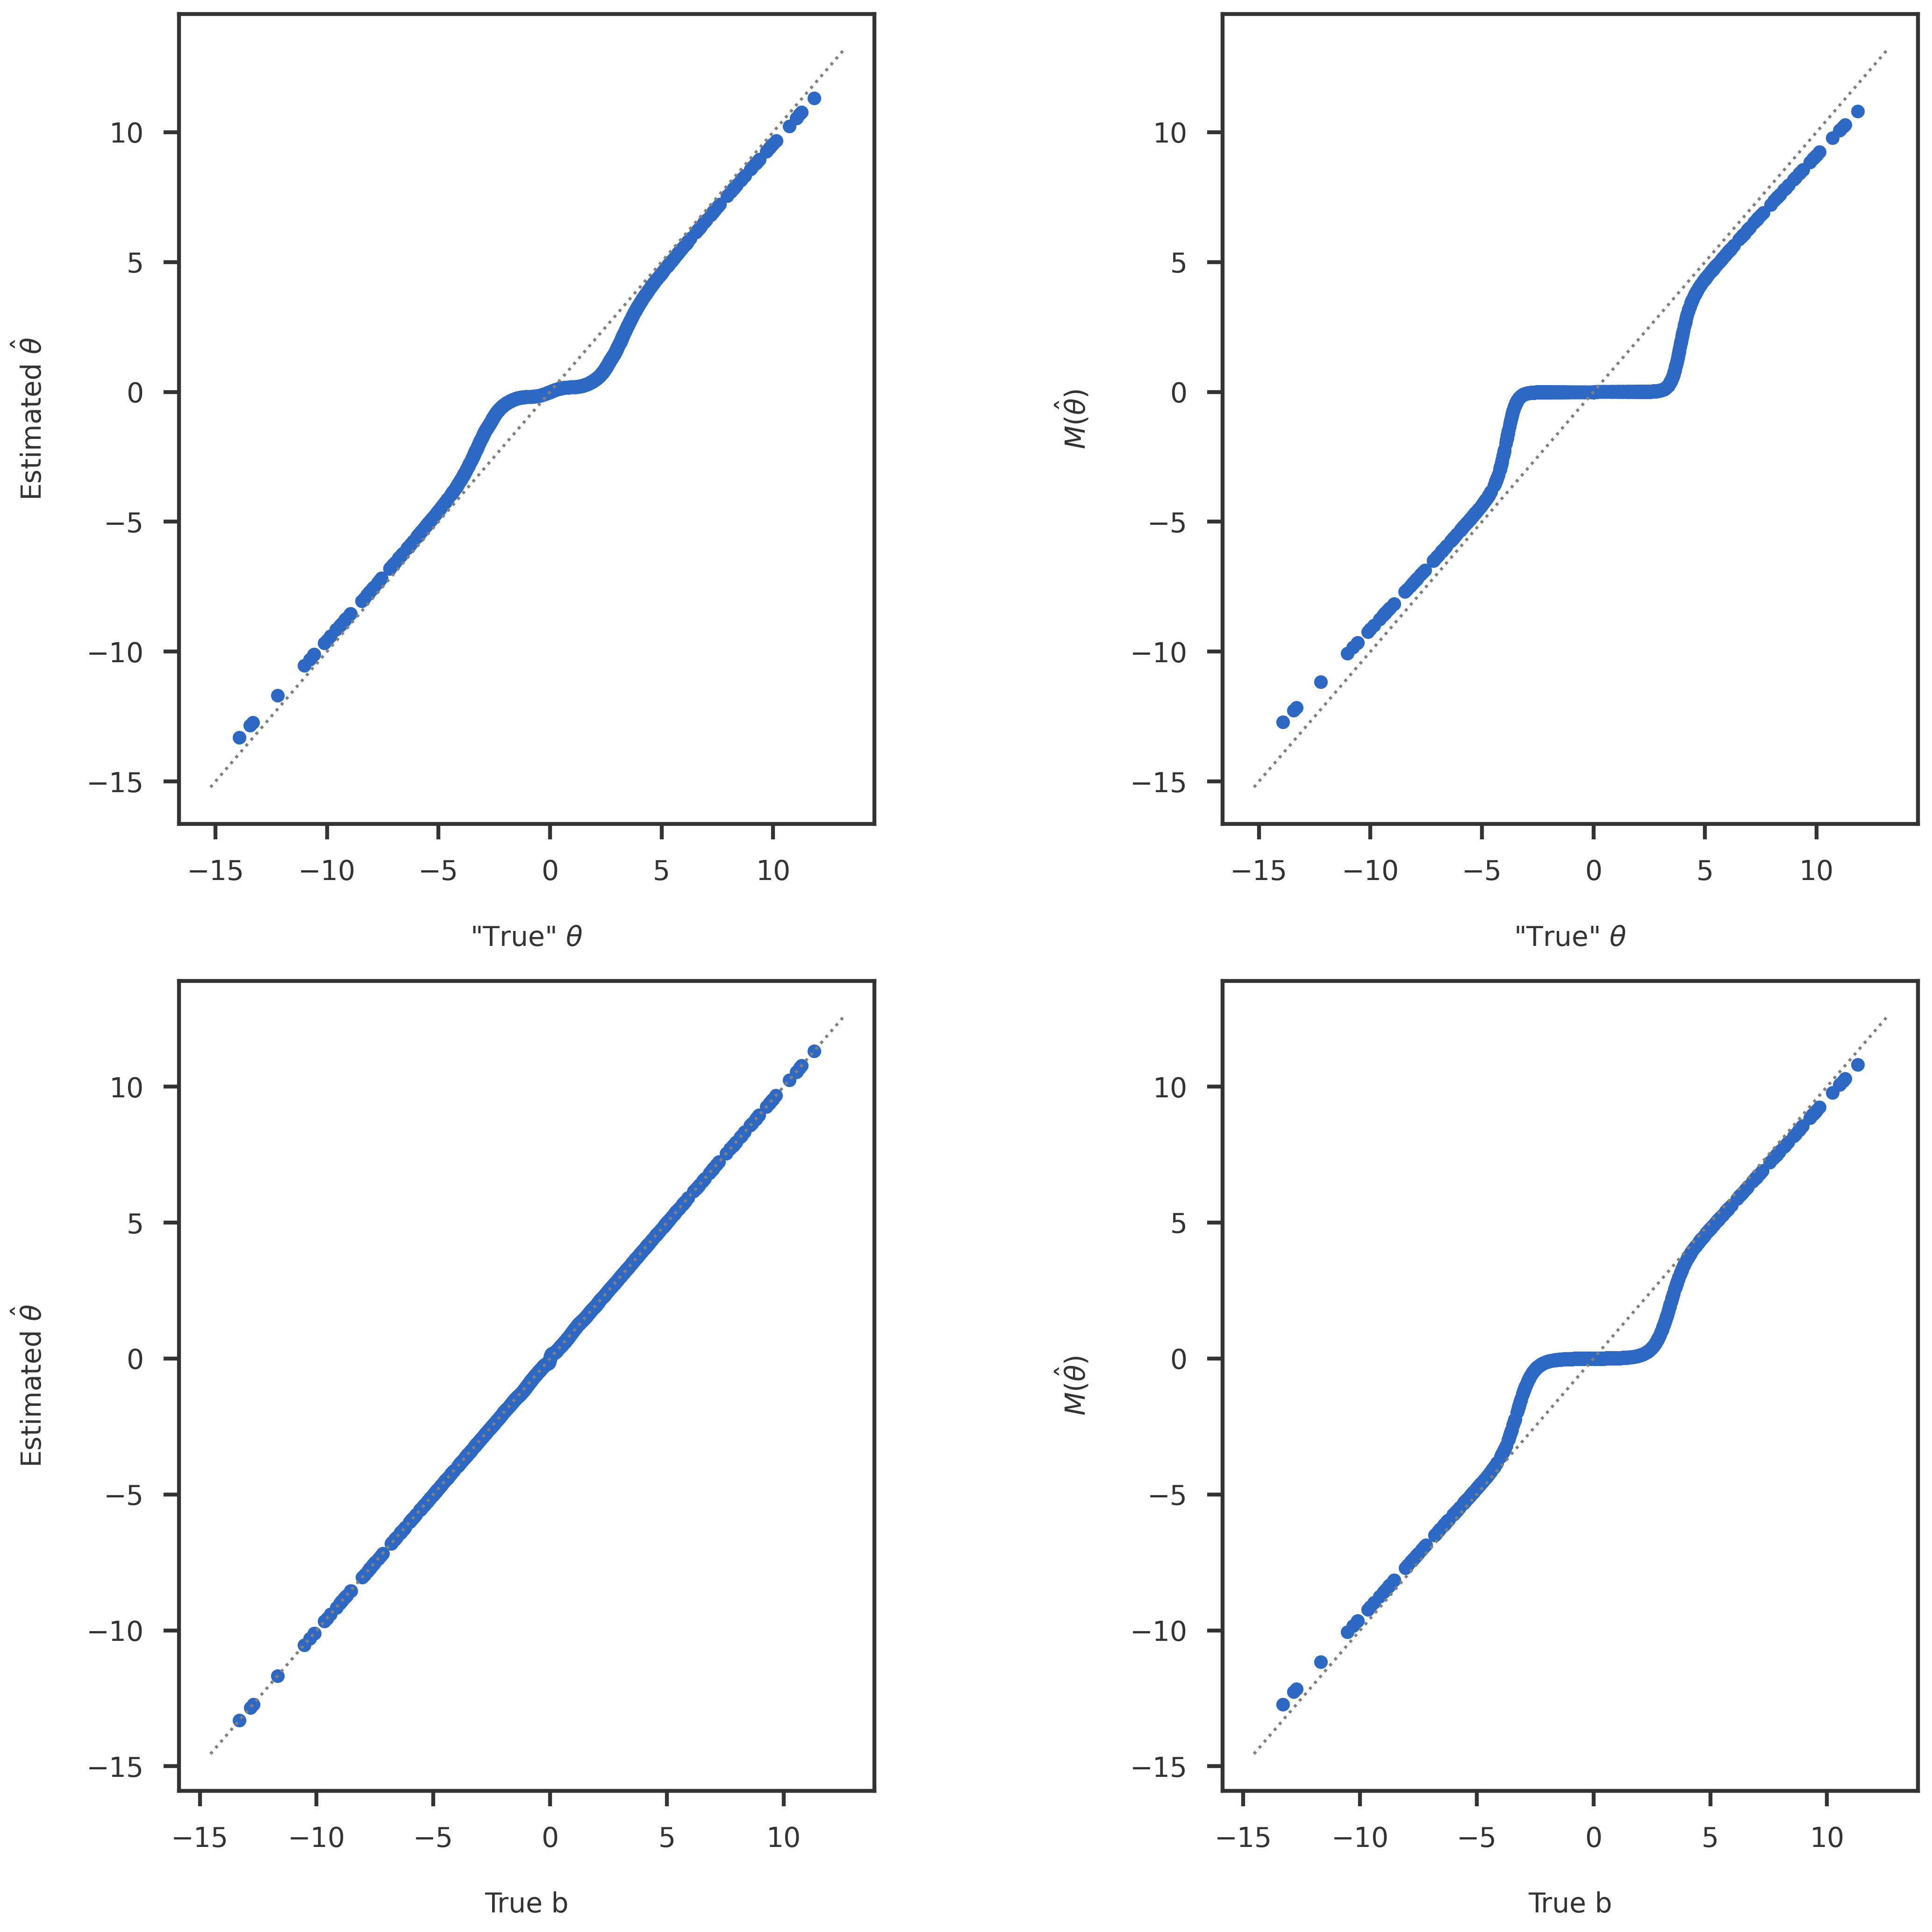

In [15]:
b_hat = plr_lbfgs.coef
z_hat = plr_lbfgs.theta
#z_target = unshrink_b(z_hat, strue, plr_lbfgs.prior, sk, dj)
#b_hat = shrink_theta(z_hat, strue, plr_lbfgs.prior, sk, dj)

fig = plt.figure(figsize = (14,14))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(z_newraph, z_hat)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel(r'''"True" $\theta$''')
ax1.set_ylabel(r"Estimated $\hat{\theta}$")

ax2.scatter(z_newraph, b_hat)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel(r'''"True" $\theta$''')
ax2.set_ylabel(r"$M(\hat{\theta})$")

ax3.scatter(btrue, z_hat)
mpl_utils.plot_diag(ax3)
ax3.set_xlabel("True b")
ax3.set_ylabel(r"Estimated $\hat{\theta}$")

ax4.scatter(z_hat, b_hat)
mpl_utils.plot_diag(ax4)
ax4.set_xlabel("True b")
ax4.set_ylabel(r"$M(\hat{\theta})$")


plt.tight_layout()
plt.subplots_adjust(wspace = 0.5)
plt.show()

In [25]:
plr_lbfgs.prior

array([9.99999755e-01, 2.44499412e-07, 1.45664759e-10, 4.34671212e-11])

In [26]:
wstr_init = ", ".join([f"{x:.3f}" for x in winit])
wstr_est  = ", ".join([f"{x:.3f}" for x in plr_lbfgs.prior])
print (f"Init mixture coefficients: {wstr_init}")
print (f"Est. mixture coefficients: {wstr_est}")

Init mixture coefficients: 0.998, 0.002, 0.000, 0.000
Est. mixture coefficients: 1.000, 0.000, 0.000, 0.000


In [46]:
def penalty_operator_subst(z, wk, std, sk, dj, bconst):
    nm = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    tvar = (std * std) / dj
    lambdaj = - nm.logML - 0.5 * np.square(z - bconst) / tvar
    lsum = np.sum(lambdaj)
    # Gradient w.r.t zj
    l_zgrad = - nm.logML_deriv - (z - bconst) / tvar
    l_wgrad = - nm.logML_wderiv
    l_wgrad = np.sum(l_wgrad, axis = 0)
    return lsum, l_zgrad, l_wgrad

def objective_numeric_subst(params, std, wk, sk, dj, bconst, p, k, softmax_base):
    zj = params[:p]
    #ak = params[p:]
    #wk = softmax(ak, base = softmax_base)
    obj, bgrad, wgrad = penalty_operator_subst(zj, wk, std, sk, dj, bconst)
    #akjac  = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
    #agrad = np.sum(wgrad * akjac, axis = 1)
    #grad = np.concatenate((bgrad, agrad))
    return obj, bgrad

In [103]:
#z = np.random.rand(p)
#z = unshrink_b(btrue, strue, wtrue, sk, dj)
z = btrue.copy()
softmax_base = np.exp(1)
winit, _ = initialize_ash_prior(k, sparsity = 0.98)
akinit   = np.log(winit + 1e-8) / np.log(softmax_base)
lgrng    = np.ones(btrue.shape[0]) * 10
wk       = softmax(akinit, base = softmax_base)

initparams = np.concatenate([z, lgrng, akinit])
cg_min = sp_optimize.minimize(objective_numeric_lagrangian, initparams,
                              args = (strue, sk, dj, btrue, p, k, softmax_base),
                              method = 'CG',
                              options = {'disp': True, 'maxiter': 100, 'return_all': True}
                             )

         Current function value: 0.106509
         Iterations: 100
         Function evaluations: 303510
         Gradient evaluations: 302


Est. w:  [1.00000000e+00 4.10139201e-20 2.43571409e-21 4.99230313e-21]
Est. Lagrangian (for non-zero b): 
[ 4.06773352e+00  9.33884196e+00 -1.11299635e+00  9.55536567e-02
  1.03702082e-02  1.49719119e-03  1.65068277e-03  1.23875763e+00
  3.67449292e+00  3.01212552e-03  2.47368946e+00  1.10775467e+00
  2.83720471e+00  9.88638915e+00  2.07044680e-01  6.28101937e-01
 -7.36907042e-04  4.97500901e+00  1.26794515e-01  5.61041828e-02
  3.10538181e-01  3.89814290e+00  9.02780414e+00  1.37369749e-02
  8.70300735e+00  4.61186129e-01  8.10229207e-01  1.37723965e-02
  1.07875162e-01  2.51230817e+00  1.46114584e-01  7.71944136e-01
  1.35772432e-01  5.37943591e-03  1.62836681e-02  8.44761046e+00
  1.92425748e-03  9.96056974e-01  6.42987098e+00  4.55155441e-03
  9.99874456e+00  6.21882263e+00  1.56728745e-01  2.71636854e-01
  9.94809744e+00  2.65773916e-01  1.82947175e+00  2.70809267e-03
  3.14130669e-03  3.01524384e+00  1.50735986e-01  9.99999997e+00
  3.11157833e-03  9.65773027e+00  3.18948685e+00 

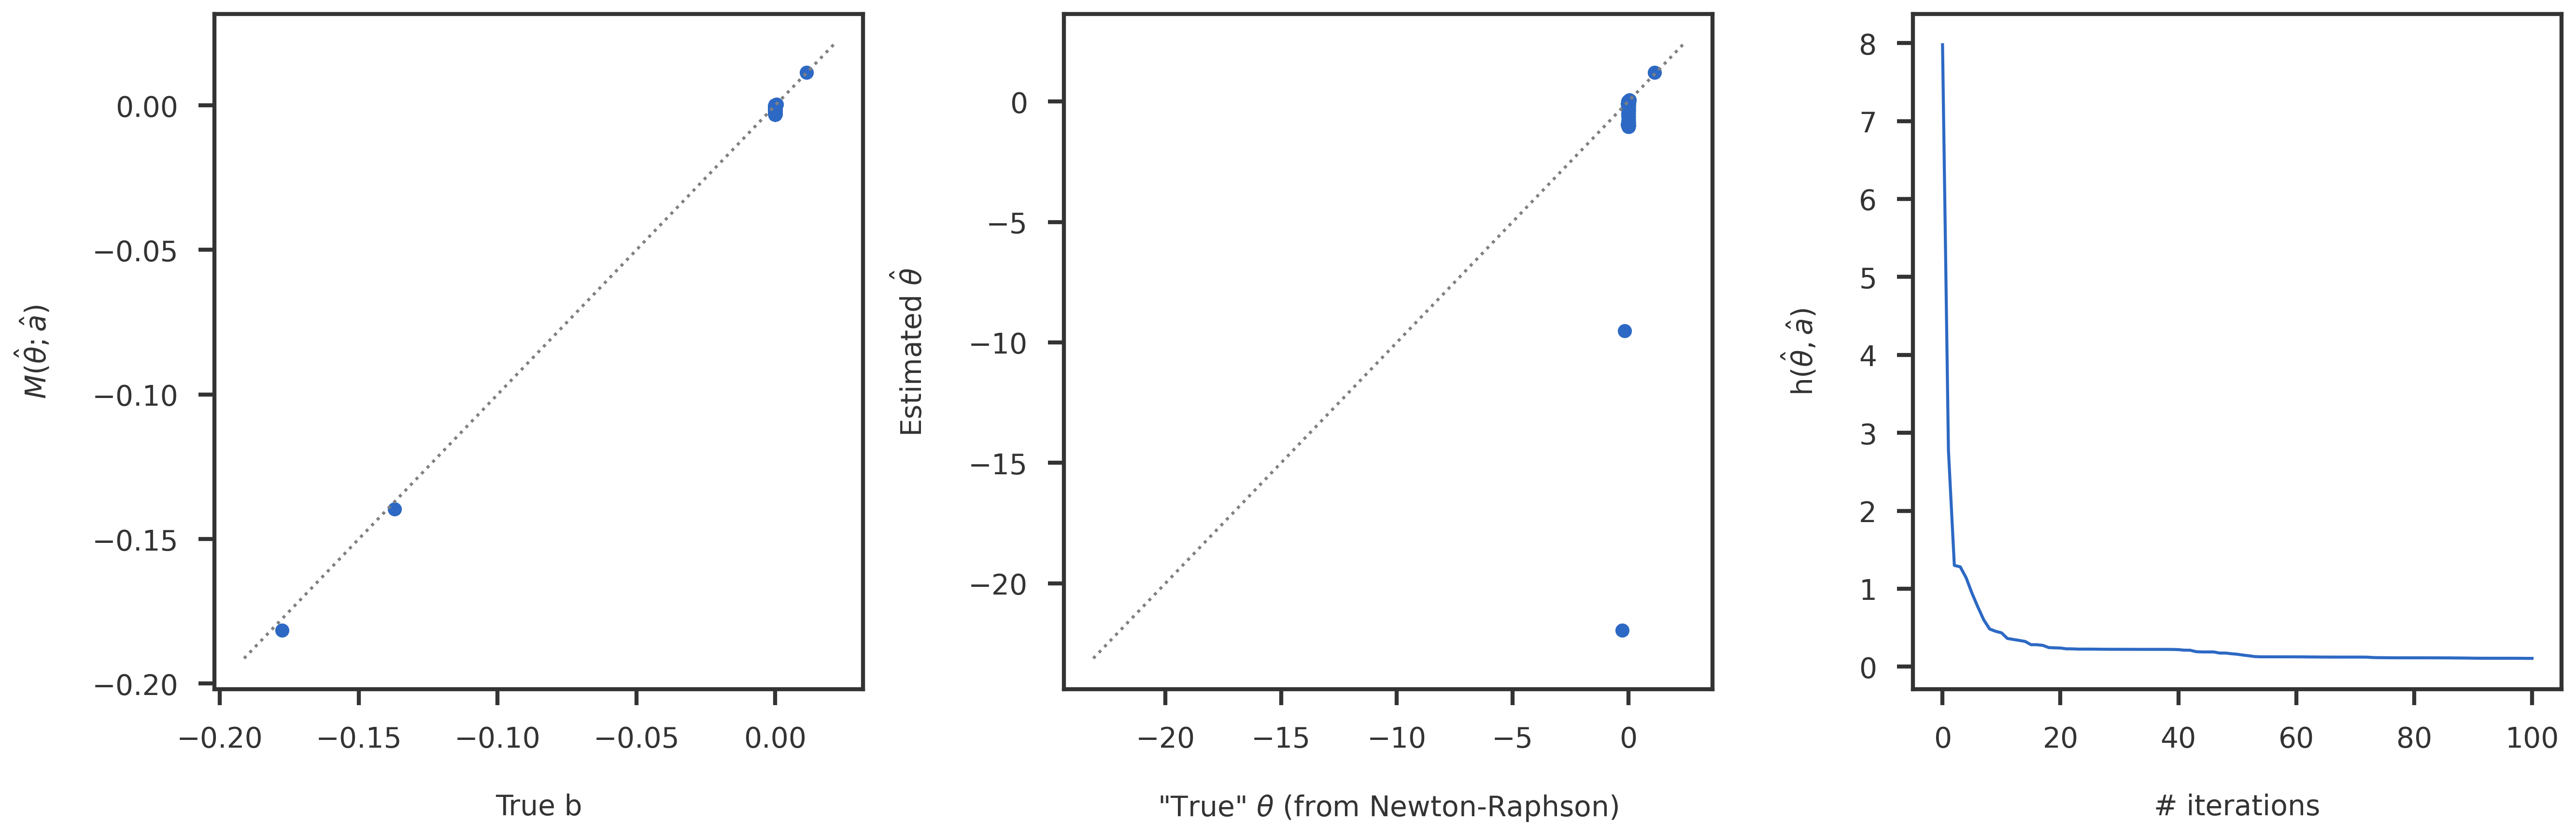

In [106]:
z_cg = cg_min.x[:p]
a_cg = cg_min.x[2*p:]
w_cg = softmax(a_cg, base = softmax_base)
lj_cg = cg_min.x[p:2*p]
#print ("True w:", wtrue)
print("Est. w: ", w_cg)
print("Est. Lagrangian (for non-zero b): ")
print(lj_cg[btrue!=0])

b_cg = shrink_theta(z_cg, strue, w_cg, sk, dj)
fig = plt.figure(figsize = (18,6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.scatter(btrue, b_cg)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel("True b")
ax1.set_ylabel(r"$M(\hat{\theta}; \hat{a})$")

ztrue = z_newraph.copy()
ax2.scatter(ztrue, z_cg)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel(r'''"True" $\theta$ (from Newton-Raphson)''')
ax2.set_ylabel(r'''Estimated $\hat{\theta}$''')

niter   = cg_min.nit
allobjs = np.zeros(niter + 1)
for i, params in enumerate(cg_min.allvecs):
    z_it = params[:p]
    a_it = params[2*p:]
    lj_it = params[p:2*p]
    w_it = softmax(a_it, base = softmax_base)
    #alllagrangian[i] = penalty_operator_lagrangian(z_it, w_it, strue, sk, dj, lj_it, btrue)
    allobjs[i] = objective_numeric_lagrangian(params, strue, sk, dj, btrue, p, k, softmax_base)
ax3.plot(np.arange(niter + 1), allobjs)
ax3.set_xlabel("# iterations")
ax3.set_ylabel(r"h($\hat{\theta}, \hat{a}$)")

plt.tight_layout()
plt.show()

In [98]:
from scipy import optimize as sp_optimize

z = z_newraph.copy()
softmax_base = np.exp(1)
winit, _ = initialize_ash_prior(k, sparsity = 0.98)
#winit    = wtrue.copy()
#akinit   = np.log(winit + 1e-8) / np.log(softmax_base)

#initparams = np.concatenate([z, akinit])
initparams = z.copy()
fmin = sp_optimize.minimize(objective_numeric_subst, initparams,
                            args = (strue, winit, sk, dj, btrue, p, k, softmax_base),
                            jac = True,
                            method = 'CG',
                            options = {'disp': True, 'maxiter': 100}
                            )

         Current function value: -11611991677374031724544.000000
         Iterations: 4
         Function evaluations: 160
         Gradient evaluations: 149


In [99]:
fmin.x[:3]

array([3.74617223e+10, 1.51977690e+11, 4.99099751e+09])

In [100]:
winit

array([0.98      , 0.00666667, 0.00666667, 0.00666667])

In [101]:
sk

array([  0.1,   1. ,  10. , 100. ])

In [102]:
dj

array([1.87502529e-01, 9.93172578e-01, 9.54212853e-01, 5.95793377e-01,
       9.08275424e-01, 7.12446393e-01, 7.81594609e-01, 3.52068399e-01,
       2.40006212e-01, 8.24520379e-01, 2.83609967e-01, 3.62982615e-01,
       2.69134928e-01, 2.60845052e-02, 5.18030522e-01, 4.19430586e-01,
       7.50876379e-01, 2.01000748e-01, 5.52390679e-01, 6.04059191e-01,
       4.85731250e-01, 2.32900849e-01, 7.78731281e-02, 9.24318884e-01,
       9.06743105e-02, 4.49834534e-01, 3.93919236e-01, 9.24531439e-01,
       5.63005795e-01, 2.82000006e-01, 5.42842026e-01, 3.98759879e-01,
       5.47817628e-01, 8.85463673e-01, 6.66269351e-01, 9.98437214e-02,
       7.10156376e-01, 3.73419435e-01, 1.60552129e-01, 6.98805089e-01,
       2.67266533e-03, 1.66401605e-01, 5.38015713e-01, 4.96875347e-01,
       1.75744249e-02, 4.98649706e-01, 3.14019405e-01, 7.96841605e-01,
       8.15148593e-01, 2.62524337e-01, 5.40713435e-01, 1.46185691e-05,
       8.09315068e-01, 4.55080398e-02, 2.56299917e-01, 3.55604470e-01,
      

array([0.25, 0.25, 0.25, 0.25])

In [88]:
std = 2.9
dj = np.random.rand(p)
obj, bgrad, wgrad = penalty_operator_subst(z, winit, std, sk, dj, btrue)
eps = 1e-6
bjgrad_num = np.zeros(btrue.shape[0])
for i in range(btrue.shape[0]):
    zeps = z.copy()
    zeps[i] += eps
    obj_eps, _, _ = penalty_operator_subst(zeps, winit, std, sk, dj, btrue)
    bjgrad_num[i] = (obj_eps - obj) / eps

In [89]:
bjgrad_num[:3]

array([-0.00294381, -0.01124818, -0.0329012 ])

In [90]:
bgrad[:3]

array([-0.00294391, -0.01124816, -0.03290112])

In [91]:
np.allclose(bgrad, bjgrad_num)

False

In [93]:
np.abs(bgrad - bjgrad_num)

2.0803089334741863e-16

In [22]:
z_newraph[:3]

array([-0.25706779, -0.16088078,  1.14020805])

In [31]:
def objective_numeric_lagrangian(params, std, sk, dj, b, p, k, softmax_base):
    zj = params[:p]
    lj = params[p:2*p]
    ak = params[2*p:]
    wk = softmax(ak, base = softmax_base)
    dLdl, dLdw, dLdt = penalty_operator_lagrangian_deriv(zj, wk, strue, sk, dj, lj, btrue)
    akjac = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
    dLda = np.sum(dLdw * akjac, axis = 1)
    obj = np.sqrt(np.sum(np.square(dLdl)) + np.sum(np.square(dLda)) + np.sum(np.square(dLdt)))
    return obj

(500,)

In [25]:
plr_lbfgs.theta[:3]

array([-0.18342486, -0.12540137,  0.00889926])